# Learn to Score a Tic-Tac-Toe Board by Example

## Implementation

The code for the basic functions used for search are implemented in [tictactoe.py](tictactoe.py). 

In [4]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
from tictactoe import random_player, play 

In [5]:
%precision 3
%pip install -q numpy pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import math

Note: you may need to restart the kernel to use updated packages.


In [17]:
df = pd.read_csv('tictactoe_data.csv')
X = df.drop('y', axis=1)
y = df['y']
print(X)
print(y)

       0  1  2  3  4  5  6  7  8
0      0  0  0  1  0  0  0  0  0
1      0  0  0  1  0  0  1 -1  0
2      0  0  0  1  0 -1  1 -1  1
3     -1  0  1  1  0 -1  1 -1  1
4     -1  1  1  1 -1 -1  1 -1  1
...   .. .. .. .. .. .. .. .. ..
20838  0  0  0  0  0  0  1  0  0
20839  0  0  0 -1  0  0  1  0  1
20840  0  1  0 -1 -1  0  1  0  1
20841 -1  1  1 -1 -1  0  1  0  1
20842 -1  1  1 -1 -1  1  1 -1  1

[20843 rows x 9 columns]
0        0
1        0
2        0
3        0
4        0
        ..
20838    1
20839    1
20840    1
20841    1
20842    1
Name: y, Length: 20843, dtype: int64


The first 9 columns are the tic-tac-toe board (0 = empty, 1 = player x, -1 player o) and the  last column y is the game outcome (0 = draw, 1 = x wins, -1 y wins)

### Train a Model

We train an artificial neural network (ANN) here, but other models like logistic regression or decision trees can also be used.

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

Split the data in training and testing data.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


clf = DecisionTreeClassifier()
%time clf = clf.fit(X_train, y_train)
clf

CPU times: user 19.2 ms, sys: 0 ns, total: 19.2 ms
Wall time: 18.2 ms


DecisionTreeClassifier()

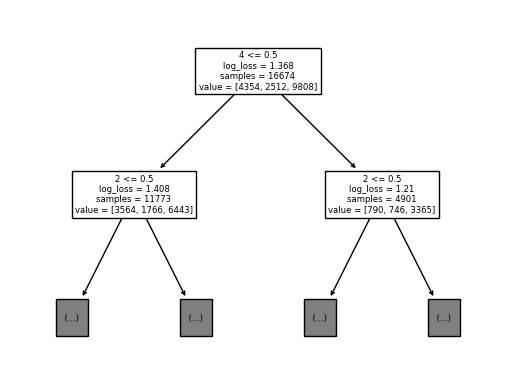

In [45]:
pl = tree.plot_tree(clf, feature_names = list(X_train.columns), max_depth=1) 

Test the model against the test data.

In [48]:
pred = clf.predict(X_test)

print("y_test:\t", list(y_test)[0:10])
print("pred:\t",   pred[0:10])

print("Accuracy:", accuracy_score(pred, y_test))

y_test:	 [1, 0, 1, -1, -1, -1, 0, -1, 1, 1]
pred:	 [ 1  0  1 -1  1  1  1 -1  1  1]
Accuracy: 0.6435596066202927


Test only on boards that have only two cells left to play.

In [19]:
take = list((X_test == 0).sum(axis=1) == 2)

X_test2 = X_test[take]
y_test2 = y_test[take]

In [20]:
pred2 = clf.predict(X_test2)
print(f"Accuracy:", accuracy_score(pred2, y_test2))

Accuracy: 0.7578419071518193


## Some Tests

We evaluate some boards where `x` just made a move. The classifier tries to predict the most likely outcome
of the game as -1 = `o` wins, 0 = draw, and 1 = `x` wins. The classifier can also predict the probability of the three possible outcomes. We can use these probabilities as weights to calculate the expected utility in the range $[-1,1]$.

In [25]:
tr = {' ': 0, 'x': 1, 'o': -1} # I translate the board into numbers

def encode_state(state):
    """Represent the board as a vector of numbers."""
    return [tr[s] for s in state]

def print_eval_board(board):
    print("Board:")
    show_board(board)

    pred = clf.predict(pd.DataFrame([encode_state(board)]))
    print("\nPredicted game outcome:", pred)

    probs = clf.predict_proba(pd.DataFrame([encode_state(board)]))
    print("Predicted probability [loss, draw, win]:", np.round(probs, 2))
    print("Expected utility: %+1.2f" % np.sum(probs * [-1,0,1]))

### x will win

Board:


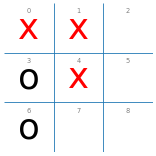


Predicted game outcome: [1]
Predicted probability [loss, draw, win]: [[0. 0. 1.]]
Expected utility: +1.00


/home/hahsler/.virtualenvs/AI/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/hahsler/.virtualenvs/AI/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [26]:
board = ['x', 'x', ' ',
         'o', 'x', ' ',
         'o', ' ', ' ']

print_eval_board(board)

### x made a mistake and will lose

Board:


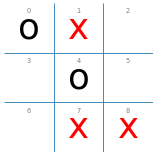


Predicted game outcome: [-1]
Predicted probability [loss, draw, win]: [[0.5 0.  0.5]]
Expected utility: +0.00


/home/hahsler/.virtualenvs/AI/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/hahsler/.virtualenvs/AI/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [27]:
board = ['o', 'x', ' ',
         ' ', 'o', ' ',
         ' ', 'x', 'x']
    
print_eval_board(board)

### This is going to be a draw

Board:


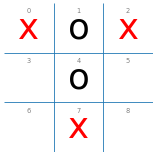


Predicted game outcome: [0]
Predicted probability [loss, draw, win]: [[0.   0.75 0.25]]
Expected utility: +0.25


/home/hahsler/.virtualenvs/AI/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/hahsler/.virtualenvs/AI/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [28]:
board = ['x', 'o', 'x',
         ' ', 'o', ' ',
         ' ', 'x', ' ']

print_eval_board(board)